This notebook combines all the nursing home data from https://data.medicare.gov/data/nursing-home-compare into one massive dataset. Currently the data is broken out into tables where there could be multiple rows per each nursing home holding different information. We pivoted the data so that each line contains all the data for one nursing home.

Each table had to go through some cleaning first (duplicate and text/description columns removed, categorical fields encoded, pivot each table and aggregate on certain fields). This notebook walks through cleaning the tables and joining them together in the end.

The tables are all stored in an Access database and come with a Metadata excel file. The individual tables are:

FireSafetyDeficiencies
HealthDeficiencies
Ownership
Penalties
ProviderInfo
QualityMsr_Claims
QualityMsr_MDS
StateAverages
SurveySummary

In [121]:
import pandas as pd
import plotly
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
import numpy as np
from functools import reduce
import datetime
import pyodbc
from math import log
import math

%matplotlib notebook
db_file = r'''data/DataMedicareGov.mdb'''
# connect to Access database with all tables

odbc_conn_str = 'DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=%s' %\
                (db_file)
conn = pyodbc.connect(odbc_conn_str)
cursor=conn.cursor()

In [86]:
#Import Star Ratings and Staffing data sets (not in access DB)
#DONT NEED THESE SEPARATELY BECAUSE ALL IN PROVIDER INFO TABLE
#Star_Ratings_raw=pd.read_csv('data/NursingHomeCompare_Revised_Flatfiles/Star_Ratings.csv')
#Staffing_raw=pd.read_csv('data/NursingHomeCompare_Revised_Flatfiles/Staffing.csv')
drop_list=['PROVNAME', 'ADDRESS', 'CITY', 'STATE', 'ZIP']

In [87]:
#getting the names of all the tables in the database
tableNames=[x[2] for x in cursor.tables().fetchall() if x[3]=='TABLE']
#read in the data from each table
for name in tableNames:
    variable=name+'_raw'
    print(variable)
    exec(variable + "=pd.read_sql_query('select * from %s' % (name), conn)")
    
    


FireSafetyDeficiencies_raw
HealthDeficiencies_raw
Ownership_raw
Penalties_raw
ProviderInfo_raw
QualityMsr_Claims_raw
QualityMsr_MDS_raw
StateAverages_raw
SurveySummary_raw


Next I went through each of the tables to decide what cleaning needed to be done on each, starting with the FireSafetyDeficiencies_raw. 

### FireSafetyDeficiencies
This dataset contains all the Fire Safety deficiencies found as part of a standard inspection or due to a complaint inspection. Since these are deficiencies, a nursing home could have more than one or they could have 0, regardless of cycle. I kept in the cycle progression to help feed our model the information if the nursing home is improving or deteriorating over time.

The tags provide more information, but I kept them out of the final data set and just went with the cound of each type of deficieny. The tags would provide sparse data when pivoted.



In [88]:
# clean up FireSafetyDeficiencies table
#sum of fire in standard vs complaint inspection, for each cycle (1,2,3)
FireSafetyDeficiencies_standard=FireSafetyDeficiencies_raw[FireSafetyDeficiencies_raw['Standard']=='Y']
FireSafetyDeficiencies_complaint=FireSafetyDeficiencies_raw[FireSafetyDeficiencies_raw['Complaint']=='Y']
#creating the standard inspection data set
FireSafetyDef_standard_counts=FireSafetyDeficiencies_standard.groupby(['PROVNUM','cycle']).size().reset_index(name='counts')
FireSafetyDef_standard_pivoted = FireSafetyDef_standard_counts.pivot(index='PROVNUM', columns='cycle', values='counts').reset_index()
FireSafetyDef_standard_pivoted.rename(columns=lambda x: 'Standard_FireSafety_cycle_{0}'.format(x) if x !='PROVNUM' else x, inplace=True)
FireSafetyDef_standard_pivoted.head()
#Creating the complaint inspection data set
FireSafetyDef_complaint_counts=FireSafetyDeficiencies_complaint.groupby(['PROVNUM','cycle']).size().reset_index(name='counts')
FireSafetyDef_complaint_pivoted = FireSafetyDef_complaint_counts.pivot(index='PROVNUM', columns='cycle', values='counts').reset_index()
FireSafetyDef_complaint_pivoted.rename(columns=lambda x: 'Complaint_FireSafety_cycle_{0}'.format(x) if x !='PROVNUM' else x, inplace=True)
FireSafetyDef_complaint_pivoted.head()

#Join together into one FireSafety data set
FireSafetyDef_total=FireSafetyDef_standard_pivoted.set_index('PROVNUM').join(FireSafetyDef_complaint_pivoted.set_index('PROVNUM'), how='outer', lsuffix='_standard')
FireSafetyDef_total=FireSafetyDef_total.reset_index()
print(list(FireSafetyDef_total))
FireSafetyDef_total.head()

['PROVNUM', 'Standard_FireSafety_cycle_1.0', 'Standard_FireSafety_cycle_2.0', 'Standard_FireSafety_cycle_3.0', 'Complaint_FireSafety_cycle_1.0', 'Complaint_FireSafety_cycle_2.0', 'Complaint_FireSafety_cycle_3.0']


cycle,PROVNUM,Standard_FireSafety_cycle_1.0,Standard_FireSafety_cycle_2.0,Standard_FireSafety_cycle_3.0,Complaint_FireSafety_cycle_1.0,Complaint_FireSafety_cycle_2.0,Complaint_FireSafety_cycle_3.0
0,015009,2.0,2.0,2.0,NaN,NaN,NaN
1,015010,3.0,2.0,2.0,NaN,NaN,NaN
2,015012,NaN,3.0,4.0,NaN,NaN,NaN
3,015014,4.0,3.0,2.0,NaN,NaN,NaN
4,015015,5.0,8.0,6.0,NaN,NaN,NaN


### Health Deficiencies
This dataset is simliar to the Fire Safety dataset, but it contains all the Health deficiencies (not Fire) found as part of a standard inspection or due to a complaint inspection. Since these are deficiencies, a nursing home could have more than one or they could have 0, regardless of cycle. I kept in the cycle progression to help feed our model the information if the nursing home is improving or deteriorating over time.

The tags provide more information, but I kept them out of the final data set and just went with the cound of each type of deficieny. The tags would provide sparse data when pivoted.

In [91]:
# clean up HealthDeficiencies table
#sum of fire in standard vs complaint inspection, for each cycle (1,2,3)
HealthDeficiencies_standard=HealthDeficiencies_raw[HealthDeficiencies_raw['Standard']=='Y']
HealthDeficiencies_complaint=HealthDeficiencies_raw[HealthDeficiencies_raw['Complaint']=='Y']
#creating the standard inspection data set
HealthDef_standard_counts=HealthDeficiencies_standard.groupby(['PROVNUM','cycle']).size().reset_index(name='counts')
HealthDef_standard_pivoted = HealthDef_standard_counts.pivot(index='PROVNUM', columns='cycle', values='counts').reset_index()
HealthDef_standard_pivoted.rename(columns=lambda x: 'Standard_Health_cycle_{0}'.format(x) if x !='PROVNUM' else x, inplace=True)
HealthDef_standard_pivoted.head()
#Creating the complaint inspection data set
HealthDef_complaint_counts=HealthDeficiencies_complaint.groupby(['PROVNUM','cycle']).size().reset_index(name='counts')
HealthDef_complaint_pivoted = HealthDef_complaint_counts.pivot(index='PROVNUM', columns='cycle', values='counts').reset_index()
HealthDef_complaint_pivoted.rename(columns=lambda x: 'Complaint_Health_cycle_{0}'.format(x) if x !='PROVNUM' else x, inplace=True)
HealthDef_complaint_pivoted.head()

#Join together into one FireSafety data set
HealthDef_total=HealthDef_standard_pivoted.set_index('PROVNUM').join(HealthDef_complaint_pivoted.set_index('PROVNUM'), how='outer', lsuffix='_standard')
HealthDef_total=HealthDef_total.reset_index()

print(list(HealthDef_total))
HealthDef_total.head()

['PROVNUM', 'Standard_Health_cycle_1.0', 'Standard_Health_cycle_2.0', 'Standard_Health_cycle_3.0', 'Complaint_Health_cycle_1.0', 'Complaint_Health_cycle_2.0', 'Complaint_Health_cycle_3.0']


cycle,PROVNUM,Standard_Health_cycle_1.0,Standard_Health_cycle_2.0,Standard_Health_cycle_3.0,Complaint_Health_cycle_1.0,Complaint_Health_cycle_2.0,Complaint_Health_cycle_3.0
0,015009,NaN,2.0,1.0,NaN,NaN,NaN
1,015010,7.0,1.0,7.0,NaN,NaN,NaN
2,015012,5.0,3.0,1.0,NaN,NaN,NaN
3,015014,6.0,3.0,6.0,NaN,3.0,3.0
4,015015,2.0,6.0,10.0,NaN,NaN,NaN


### Ownership
The Ownership table shows the breakdown of who owns the nursing home and what 'Type' (Individual or Organization). Our thought is that this might be important when determining the quality of the nursing home and therefore might influence the readmission rate.

#### Challenges: 
Some breakdowns sum to more and less than 100, which doesnt really make sense. This might be due to name changes and how Medicare keeps track of these ownership entities. But what we can do is change this metric to be 1 if Individuals own more part of the NH than Organizations, and -1 if the other way around. We will come back to this later.


In [92]:
#Clean up Ownership table


Ownership_flt=Ownership_raw[(Ownership_raw.OWNER_PERCENTAGE!='NOT APPLICABLE')&(Ownership_raw.OWNER_PERCENTAGE!='NO PERCENTAGE PROVIDED')&(Ownership_raw.OWNER_PERCENTAGE!='None')]
Ownership_flt['OWNER_PERCENTAGE']=Ownership_flt['OWNER_PERCENTAGE'].apply(str)
Ownership_flt['OWNER_PERCENTAGE']=Ownership_flt['OWNER_PERCENTAGE'].apply(lambda x: x.strip('%'))
Ownership_flt['OWNER_PERCENTAGE']=pd.to_numeric(Ownership_flt['OWNER_PERCENTAGE'],errors='coerce')

Ownership_pivoted = Ownership_flt.pivot_table(index='PROVNUM', columns='OWNER_TYPE', values='OWNER_PERCENTAGE',aggfunc=np.sum).reset_index()
Ownership_pivoted.set_index('PROVNUM')
print(list(Ownership_pivoted))
Ownership_pivoted.head(10)

C:\Users\hanna\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\hanna\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



['PROVNUM', 'Individual', 'Organization']


C:\Users\hanna\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



OWNER_TYPE,PROVNUM,Individual,Organization
0,015009,91.0,NaN
1,015014,100.0,NaN
2,015015,100.0,NaN
3,015016,71.0,128.0
4,015019,NaN,100.0
5,015023,100.0,NaN
6,015027,89.0,110.0
7,015028,NaN,100.0
8,015031,100.0,NaN
9,015034,89.0,110.0


Here is an example of one of those entries that sum to more than 100%.

In [94]:
Ownership_provnum=Ownership_flt[Ownership_flt['PROVNUM']=='015016']
Ownership_provnum.head()

,PROVNUM,PROVNAME,ADDRESS,CITY,STATE,ZIP,ROLE_DESC,OWNER_TYPE,OWNER_NAME,OWNER_PERCENTAGE,ASSOCIATION_DATE,filedate
25,015016,ATHENS HEALTH AND REHABILITATION LLC,611 WEST MARKET STREET,ATHENS,AL,35611,5% OR GREATER DIRECT OWNERSHIP INTEREST,Organization,"NORTHPORT HOLDING OPERATIONS, LLC",100.0,since 10/06/2015,2018-02-01
26,015016,ATHENS HEALTH AND REHABILITATION LLC,611 WEST MARKET STREET,ATHENS,AL,35611,5% OR GREATER INDIRECT OWNERSHIP INTEREST,Organization,JAMES N ESTES JR FAMILY DYNASTY TR NO 2,8.0,since 10/06/2015,2018-02-01
27,015016,ATHENS HEALTH AND REHABILITATION LLC,611 WEST MARKET STREET,ATHENS,AL,35611,5% OR GREATER INDIRECT OWNERSHIP INTEREST,Organization,JAMES NORMAN ESTES JR TR,6.0,since 10/06/2015,2018-02-01
28,015016,ATHENS HEALTH AND REHABILITATION LLC,611 WEST MARKET STREET,ATHENS,AL,35611,5% OR GREATER INDIRECT OWNERSHIP INTEREST,Organization,JENNIFER E AGEE FAMILY DYNASTY TR NO 2,8.0,since 10/06/2015,2018-02-01
29,015016,ATHENS HEALTH AND REHABILITATION LLC,611 WEST MARKET STREET,ATHENS,AL,35611,5% OR GREATER INDIRECT OWNERSHIP INTEREST,Organization,JENNIFER LEE ESTES TR 031093,6.0,since 10/06/2015,2018-02-01


### Penalties table
The Penalties table contains all the fines (amounts) and payment denials (days to pay) for that nursing home. We grouped these by cound and the sum of their respective metric.

Not all nursing homes will have an entry because penalties are not something a NH wants to get.

In [95]:
#Clean up Penalties table
Penalties_raw['fine_amt']=pd.to_numeric(Penalties_raw['fine_amt'],errors='coerce')
Penalties_raw['payden_days']=pd.to_numeric(Penalties_raw['payden_days'],errors='coerce')

Penalties_fine=Penalties_raw[Penalties_raw['pnlty_type']=='Fine'].set_index('provnum')
PenaltyCounts_fine=Penalties_fine.groupby(['provnum']).agg({'pnlty_type':'count', 'fine_amt':'sum'}).rename(columns={'pnlty_type':'penalty_count'})
PenaltyCounts_fine.rename(columns=lambda x: 'Fine_{0}'.format(x) if x !='PROVNUM' else x, inplace=True)

#Payment Denial
Penalties_PD=Penalties_raw[Penalties_raw['pnlty_type']=='Payment Denial'].set_index('provnum')
PenaltyCounts_PD=Penalties_PD.groupby(['provnum']).agg({'pnlty_type':'count', 'payden_days':'sum'}).rename(columns={'pnlty_type':'penalty_count'})
PenaltyCounts_PD.rename(columns=lambda x: 'Payment_den_{0}'.format(x) if x !='PROVNUM' else x, inplace=True)

#Join tables
PenaltyCounts_total=PenaltyCounts_fine.join(PenaltyCounts_PD, how='outer', lsuffix='_standard')

PenaltyCounts_total=PenaltyCounts_total.reset_index().rename(columns={'provnum':'PROVNUM'})
print(list(PenaltyCounts_total))
PenaltyCounts_total.head()

['PROVNUM', 'Fine_penalty_count', 'Fine_fine_amt', 'Payment_den_penalty_count', 'Payment_den_payden_days']


,PROVNUM,Fine_penalty_count,Fine_fine_amt,Payment_den_penalty_count,Payment_den_payden_days
0,015010,1.0,15259.0,1.0,21.0
1,015031,1.0,146070.0,NaN,NaN
2,015037,2.0,342843.0,1.0,12.0
3,015045,1.0,243003.0,NaN,NaN
4,015047,1.0,13260.0,NaN,NaN


### Provider info
The provider table contains all the location and name information, as well as staffing hours and star ratings. This table is already in the format of one line per nursing home, so we just removed the FileDate.

In [96]:
#No need to clean because it has one line for each provider
ProviderInfo_flt=ProviderInfo_raw.drop(['FILEDATE'], axis=1)
Prov_dup=ProviderInfo_raw.duplicated(subset='PROVNUM')
Prov_true=Prov_dup[Prov_dup==True]
print(list(ProviderInfo_flt))

print(Prov_true)
ProviderInfo_flt.head()

['PROVNUM', 'PROVNAME', 'ADDRESS', 'CITY', 'STATE', 'ZIP', 'PHONE', 'COUNTY_SSA', 'COUNTY_NAME', 'OWNERSHIP', 'BEDCERT', 'RESTOT', 'CERTIFICATION', 'INHOSP', 'LBN', 'PARTICIPATION_DATE', 'CCRC_FACIL', 'SFF', 'OLDSURVEY', 'CHOW_LAST_12MOS', 'RESFAMCOUNCIL', 'SPRINKLER_STATUS', 'OVERALL_RATING', 'overall_rating_fn', 'SURVEY_RATING', 'survey_rating_fn', 'QUALITY_RATING', 'quality_rating_fn', 'STAFFING_RATING', 'staffing_rating_fn', 'RN_STAFFING_RATING', 'RN_staffing_rating_fn', 'STAFFING_FLAG', 'PT_STAFFING_FLAG', 'AIDHRD', 'VOCHRD', 'RNHRD', 'TOTLICHRD', 'TOTHRD', 'PTHRD', 'EXP_AIDE', 'EXP_LPN', 'EXP_RN', 'EXP_TOTAL', 'ADJ_AIDE', 'ADJ_LPN', 'ADJ_RN', 'ADJ_TOTAL', 'R_SRVY_DT_F', 'R_TOT_HTH_DFCNCY', 'R_HTH_SVRTY', 'R_HTH_SCOPE', 'PREV_SRVY_DT_F', 'PREV_TOT_HTH_DFCNCY', 'CYCLE_1_SURVEY_DATE', 'CYCLE_1_DEFS', 'CYCLE_1_NFROMDEFS', 'CYCLE_1_NFROMCOMP', 'CYCLE_1_DEFS_SCORE', 'CYCLE_1_NUMREVIS', 'CYCLE_1_REVISIT_SCORE', 'CYCLE_1_TOTAL_SCORE', 'CYCLE_2_SURVEY_DATE', 'CYCLE_2_DEFS', 'CYCLE_2_NFROM

,PROVNUM,PROVNAME,ADDRESS,CITY,STATE,ZIP,PHONE,COUNTY_SSA,COUNTY_NAME,OWNERSHIP,...,CYCLE_2_NUMREVIS,CYCLE_2_REVISIT_SCORE,CYCLE_2_TOTAL_SCORE,WEIGHTED_ALL_CYCLES_SCORE,INCIDENT_CNT,CMPLNT_CNT,FINE_CNT,FINE_TOT,PAYDEN_CNT,TOT_PENLTY_CNT
0,015009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,2563324110,290,Franklin,For profit - Individual,...,1.0,0.0,8.0,3.200,0.0,0.0,0.0,0.0,0.0,0.0
1,015010,COOSA VALLEY NURSING FACILITY,315 WEST HICKORY STREET,SYLACAUGA,AL,35150,2562495604,600,Talladega,For profit - Corporation,...,1.0,0.0,16.0,28.000,0.0,0.0,1.0,15259.0,1.0,2.0
2,015012,HIGHLANDS HEALTH AND REHAB,380 WOODS COVE ROAD,SCOTTSBORO,AL,35768,2562183708,350,Jackson,Government - County,...,1.0,0.0,12.0,31.200,0.0,0.0,0.0,0.0,0.0,0.0
3,015014,EASTVIEW REHABILITATION & HEALTHCARE CENTER,7755 FOURTH AVENUE SOUTH,BIRMINGHAM,AL,35206,2058330146,360,Jefferson,For profit - Corporation,...,1.0,0.0,24.0,33.600,0.0,1.0,0.0,0.0,0.0,0.0
4,015015,PLANTATION MANOR NURSING HOME,6450 OLD TUSCALOOSA HIGHWAY P O BOX 97,MC CALLA,AL,35111,2054776161,360,Jefferson,For profit - Corporation,...,1.0,0.0,24.0,19.200,0.0,0.0,0.0,0.0,0.0,0.0


### Quality MSR Claims
The Quality MSR Claims table holds the three variables we want to predict:
521- Percentage of short-stay residents who were rehospitalized after a nursing home admission
522- Percentage of short-stay residents who had an outpatient emergency department visit
523- Percentage of short-stay residents who were successfully discharged to the community

These metrics are all for short stay patients and they were all included in calculating the 5 star MSR.

#### Challenges
1) We need to transform all the percentages using Logit to create continuous numbers. Percentages only go from 0-100 and we do not want the model to predict outside those boundries. Converting the values to Logit will handle this issue.

2) Some data is missing. About 6,000 of these entries are blank because the number of residents was too low to report on(SCORE_FN notes). About 1,000 are truly missing. Since the nursing home might have the other metrics, we will leave the missing values as blanks.

3) Need to change the code to skip the 0s and 1s in the data transformation step since log(0) and log(1/0) are NaN and error out.

In [139]:
#Clean QualityMsr_Claims table

QualityMsr_Claims_group=QualityMsr_Claims_raw.groupby(['PROVNUM', 'STAY_TYPE']).STAY_TYPE.nunique()
#There are no providers with more than one stay_type, only short stay
print(QualityMsr_Claims_raw.STAY_TYPE.unique())

QualityMsr_Claims_pivoted = QualityMsr_Claims_raw.pivot(index='PROVNUM', columns='MSR_CD', values='SCORE_ADJUSTED').reset_index()
QualityMsr_Claims_pivoted.rename(columns=lambda x: 'MSR_{0}_SCORE_ADJUSTED'.format(x) if x != 'PROVNUM' else x, inplace=True)
#Convert to number
QualityMsr_Claims_transformed=QualityMsr_Claims_pivoted
QualityMsr_Claims_transformed['MSR_521_SCORE_ADJUSTED']=pd.to_numeric(QualityMsr_Claims_transformed['MSR_521_SCORE_ADJUSTED'],errors='coerce')
QualityMsr_Claims_transformed['MSR_522_SCORE_ADJUSTED']=pd.to_numeric(QualityMsr_Claims_transformed['MSR_522_SCORE_ADJUSTED'],errors='coerce')
QualityMsr_Claims_transformed['MSR_523_SCORE_ADJUSTED']=pd.to_numeric(QualityMsr_Claims_transformed['MSR_523_SCORE_ADJUSTED'],errors='coerce')
#Transform data using logit [FIX THIS]

#QualityMsr_Claims_transformed[['MSR_521_SCORE_ADJUSTED', 'MSR_522_SCORE_ADJUSTED','MSR_523_SCORE_ADJUSTED']]=QualityMsr_Claims_transformed[['MSR_521_SCORE_ADJUSTED', 'MSR_522_SCORE_ADJUSTED','MSR_523_SCORE_ADJUSTED']].apply(lambda x: (log((x/100)/(1-(x/100)))))
#QualityMsr_Claims_transformed['MSR_523_SCORE_ADJUSTED']=QualityMsr_Claims_transformed['MSR_523_SCORE_ADJUSTED'].apply(lambda x: (log((x/100)/(1-(x/100)))) if x!=0 or x!=1 else x)

print(list(QualityMsr_Claims_transformed))
print(QualityMsr_Claims_transformed.iloc[1,2].dtype)
QualityMsr_Claims_transformed.head()

['Short Stay']
['PROVNUM', 'MSR_521_SCORE_ADJUSTED', 'MSR_522_SCORE_ADJUSTED', 'MSR_523_SCORE_ADJUSTED']
float64


MSR_CD,PROVNUM,MSR_521_SCORE_ADJUSTED,MSR_522_SCORE_ADJUSTED,MSR_523_SCORE_ADJUSTED
0,015009,19.568445,11.890019,65.525299
1,015010,23.754278,8.960375,60.300267
2,015012,25.860992,12.852521,59.890425
3,015014,29.200983,15.477668,NaN
4,015015,21.959195,13.422313,58.268166


<IPython.core.display.Javascript object>


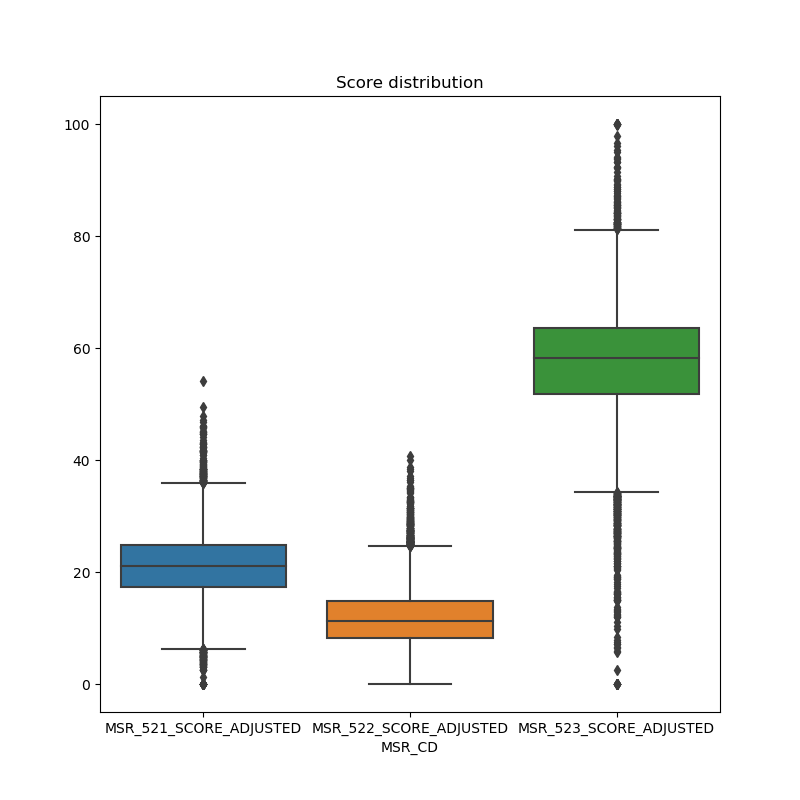

In [140]:
a4_dims=(8,8)
fig, ax= plt.subplots(figsize=a4_dims, facecolor='w')

ax = sns.boxplot(data=QualityMsr_Claims_pivoted).set_title('Score distribution')


### Quality MSR MDS
The Quality MSR MDS table contains many more metrics about the nursing home. 

We are keeping in each quarter, as it might help show changes over time.

#### Questions:
1) Not sure if all of these metrics need to be normalized using logit as well. They are inputs, so the model will never mistakently predict these values outside the range of a percentage. But there is a rule for when you normalize outputs you should normalize inputs. Or we should just normalize ALL inputs, so one does not over power the others in how much they contribue to the model. We need to do this.


In [99]:
#Clean QualityMsr_MDS table

Stay={'Long Stay':1, 'Short Stay':-1}
print(QualityMsr_MDS_raw.STAY_TYPE.unique())
QualityMsr_MDS_flt=QualityMsr_MDS_raw.filter(items=['PROVNUM', 'MSR_CD', 'STAY_TYPE','Q1_MEASURE_SCORE', 'Q2_MEASURE_SCORE', 'Q3_MEASURE_SCORE', 'Q4_MEASURE_SCORE'])
#Stay Type
QualityMsr_MDS_staytype = QualityMsr_MDS_flt.pivot(index='PROVNUM', columns='MSR_CD', values='STAY_TYPE').reset_index()
QualityMsr_MDS_staytype.rename(columns=lambda x: 'MSR_{0}_STAY_TYPE'.format(x) if x != 'PROVNUM' else x, inplace=True)
QualityMsr_MDS_staytype=QualityMsr_MDS_staytype.replace(['Long Stay', 'Short Stay'], [1,-1])
#'Q1_MEASURE_SCORE'
QualityMsr_MDS_Q1MS = QualityMsr_MDS_flt.pivot(index='PROVNUM', columns='MSR_CD', values='Q1_MEASURE_SCORE').reset_index()
QualityMsr_MDS_Q1MS.rename(columns=lambda x: 'MSR_{0}_Q1_MEASURE_SCORE'.format(x) if x != 'PROVNUM' else x, inplace=True)


#'Q2_MEASURE_SCORE'
QualityMsr_MDS_Q2MS = QualityMsr_MDS_flt.pivot(index='PROVNUM', columns='MSR_CD', values='Q2_MEASURE_SCORE').reset_index()
QualityMsr_MDS_Q2MS.rename(columns=lambda x: 'MSR_{0}_Q2_MEASURE_SCORE'.format(x) if x != 'PROVNUM' else x, inplace=True)
#'Q3_MEASURE_SCORE'
QualityMsr_MDS_Q3MS = QualityMsr_MDS_flt.pivot(index='PROVNUM', columns='MSR_CD', values='Q3_MEASURE_SCORE').reset_index()
QualityMsr_MDS_Q3MS.rename(columns=lambda x: 'MSR_{0}_Q3_MEASURE_SCORE'.format(x) if x != 'PROVNUM' else x, inplace=True)
#'Q4_MEASURE_SCORE'
QualityMsr_MDS_Q4MS = QualityMsr_MDS_flt.pivot(index='PROVNUM', columns='MSR_CD', values='Q4_MEASURE_SCORE').reset_index()
QualityMsr_MDS_Q4MS.rename(columns=lambda x: 'MSR_{0}_Q4_MEASURE_SCORE'.format(x) if x != 'PROVNUM' else x, inplace=True)

tables=[QualityMsr_MDS_staytype,QualityMsr_MDS_Q1MS,QualityMsr_MDS_Q2MS,QualityMsr_MDS_Q3MS,QualityMsr_MDS_Q4MS]
QualityMsr_MDS_final=reduce(lambda left, right: pd.merge(left,right, on='PROVNUM', how='outer'),tables)
print(list(QualityMsr_MDS_final))
QualityMsr_MDS_final.head(5)

['Long Stay' 'Short Stay']
['PROVNUM', 'MSR_401_STAY_TYPE', 'MSR_402_STAY_TYPE', 'MSR_403_STAY_TYPE', 'MSR_404_STAY_TYPE', 'MSR_405_STAY_TYPE', 'MSR_406_STAY_TYPE', 'MSR_407_STAY_TYPE', 'MSR_408_STAY_TYPE', 'MSR_409_STAY_TYPE', 'MSR_410_STAY_TYPE', 'MSR_411_STAY_TYPE', 'MSR_415_STAY_TYPE', 'MSR_419_STAY_TYPE', 'MSR_424_STAY_TYPE', 'MSR_425_STAY_TYPE', 'MSR_426_STAY_TYPE', 'MSR_430_STAY_TYPE', 'MSR_434_STAY_TYPE', 'MSR_451_STAY_TYPE', 'MSR_452_STAY_TYPE', 'MSR_471_STAY_TYPE', 'MSR_401_Q1_MEASURE_SCORE', 'MSR_402_Q1_MEASURE_SCORE', 'MSR_403_Q1_MEASURE_SCORE', 'MSR_404_Q1_MEASURE_SCORE', 'MSR_405_Q1_MEASURE_SCORE', 'MSR_406_Q1_MEASURE_SCORE', 'MSR_407_Q1_MEASURE_SCORE', 'MSR_408_Q1_MEASURE_SCORE', 'MSR_409_Q1_MEASURE_SCORE', 'MSR_410_Q1_MEASURE_SCORE', 'MSR_411_Q1_MEASURE_SCORE', 'MSR_415_Q1_MEASURE_SCORE', 'MSR_419_Q1_MEASURE_SCORE', 'MSR_424_Q1_MEASURE_SCORE', 'MSR_425_Q1_MEASURE_SCORE', 'MSR_426_Q1_MEASURE_SCORE', 'MSR_430_Q1_MEASURE_SCORE', 'MSR_434_Q1_MEASURE_SCORE', 'MSR_451_Q1_MEAS

MSR_CD,PROVNUM,MSR_401_STAY_TYPE,MSR_402_STAY_TYPE,MSR_403_STAY_TYPE,MSR_404_STAY_TYPE,MSR_405_STAY_TYPE,MSR_406_STAY_TYPE,MSR_407_STAY_TYPE,MSR_408_STAY_TYPE,MSR_409_STAY_TYPE,...,MSR_415_Q4_MEASURE_SCORE,MSR_419_Q4_MEASURE_SCORE,MSR_424_Q4_MEASURE_SCORE,MSR_425_Q4_MEASURE_SCORE,MSR_426_Q4_MEASURE_SCORE,MSR_430_Q4_MEASURE_SCORE,MSR_434_Q4_MEASURE_SCORE,MSR_451_Q4_MEASURE_SCORE,MSR_452_Q4_MEASURE_SCORE,MSR_471_Q4_MEASURE_SCORE
0,015009,1,1,1,1,1,1,1,1,1,...,100.000000,29.545450,0.000000,0.884163,100.000000,100.000000,0.000000,32.260450,43.902440,71.512891
1,015010,1,1,1,1,1,1,1,1,1,...,100.000000,24.074070,22.857140,0.502414,97.000000,100.000000,0.000000,8.548780,37.254900,79.961060
2,015012,1,1,1,1,1,1,1,1,1,...,100.000000,5.882350,22.619050,1.161557,92.708333,93.750000,0.000000,36.591239,50.000000,62.261294
3,015014,1,1,1,1,1,1,1,1,1,...,86.250000,14.285710,None,0.000000,46.153846,41.379310,0.000000,29.270884,18.421050,None
4,015015,1,1,1,1,1,1,1,1,1,...,100.000000,26.829270,0.000000,0.000000,85.714286,98.795180,4.761900,10.785617,39.189190,40.072322


Dont think we are going to use the StateAverages table. Maybe to indicate if the nursing home was above or below the average?

In [101]:
#Clean StateAverages table
StateAverages_raw.head()

,state,C1_HLTH_DEFS_CNT,C1_FS_DEFS_CNT,C2_HLTH_DEFS_CNT,C2_FS_DEFS_CNT,C3_HLTH_DEFS_CNT,C3_FS_DEFS_CNT,PREV_HTH_AVG,aidhrd,vochrd,...,qm426,qm430,qm434,qm451,qm452,qm471,qm521,qm522,qm523,FILEDATE
0,NATION,NA,NA,NA,NA,NA,NA,5.8,2.45,0.86,...,81.015679,83.102021,1.988942,18.212429,22.714039,67.477116,21.100399,11.859065,57.029432,2018-02-01
1,AK,NA,NA,NA,NA,NA,NA,9.6,3.99,0.76,...,84.711631,81.539606,1.649192,20.607329,18.559271,73.037275,12.200076,8.222515,68.127998,2018-02-01
2,AL,NA,NA,NA,NA,NA,NA,4.1,2.61,0.97,...,81.366060,83.592355,2.090647,15.099853,29.060087,62.208462,21.743648,10.583969,58.989532,2018-02-01
3,AR,NA,NA,NA,NA,NA,NA,4.5,2.81,1.01,...,80.615471,82.904923,2.310746,15.590108,25.993207,69.468675,24.889758,15.955479,52.440853,2018-02-01
4,AZ,NA,NA,NA,NA,NA,NA,3.7,2.56,1.00,...,88.374707,91.863858,1.313632,19.805232,21.923227,64.849191,21.481093,11.788992,62.972374,2018-02-01


In [102]:
#SurveySummary

#I think we want cycle one because it's the most recent. All nursing homes should have a cycle one.
SurveySummary_flt=SurveySummary_raw[SurveySummary_raw['CYCLE']==1.0].rename(columns={'CYCLE':'SURVEY_CYCLE'}).drop(drop_list, axis=1)
print(list(SurveySummary_flt))
SurveySummary_flt.head()

['PROVNUM', 'SURVEY_CYCLE', 'HLTHSRVY_POST20171128', 'H_SURVEY_DATE', 'F_SURVEY_DATE', 'H_TOT_DFCNCY', 'F_TOT_DFCNCY', 'H_ABS_NEG_EXP_N', 'H_QOC_QOL_N', 'H_CARE_PLAN_N', 'H_NRS_MD_SVC_N', 'H_RES_RIGHTS_N', 'H_NUTRITION_N', 'H_PHARMACY_N', 'H_ENVIRONMENTAL_N', 'H_ADMINISTRATION_N', 'F_EMRGNCY_PREP_N', 'F_SPRINKLER_N', 'F_CONSTRUCTION_N', 'F_SERVICES_N', 'F_CORRIDOR_DOORS_N', 'F_EGRESS_N', 'F_ELECTRICAL_N', 'F_EMERGENCY_PLAN_N', 'F_FIRE_ALARM_N', 'F_SMOKE_N', 'F_INTERIOR_N', 'F_GAS_VAC_ELEC_N', 'F_HAZARD_AREA_N', 'F_ILLUMINATION_N', 'F_LABORATORIES_N', 'F_MEDICAL_GAS_N', 'F_SMOKING_REG_N', 'F_MISCELLANEOUS_N', 'FILEDATE']


,PROVNUM,SURVEY_CYCLE,HLTHSRVY_POST20171128,H_SURVEY_DATE,F_SURVEY_DATE,H_TOT_DFCNCY,F_TOT_DFCNCY,H_ABS_NEG_EXP_N,H_QOC_QOL_N,H_CARE_PLAN_N,...,F_SMOKE_N,F_INTERIOR_N,F_GAS_VAC_ELEC_N,F_HAZARD_AREA_N,F_ILLUMINATION_N,F_LABORATORIES_N,F_MEDICAL_GAS_N,F_SMOKING_REG_N,F_MISCELLANEOUS_N,FILEDATE
0,015009,1.0,N,2017-06-22,2017-06-29,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,2018-02-01
3,015010,1.0,N,2017-04-06,2017-04-11,7,3,0,1,2,...,3,0,0,0,0,0,0,0,0,2018-02-01
6,015012,1.0,N,2017-03-16,2017-03-16,5,0,0,1,0,...,0,0,0,0,0,0,0,0,0,2018-02-01
9,015014,1.0,N,2016-10-20,2016-10-26,6,4,0,2,0,...,0,0,0,0,0,0,0,0,0,2018-02-01
12,015015,1.0,N,2017-03-09,2017-03-16,2,5,2,0,0,...,2,0,1,0,0,0,0,0,0,2018-02-01


In [ ]:
#Clean Star_Ratings
#DONT NEED THESE SEPARATELY BECAUSE ALL IN PROVIDER INFO TABLE
#Star_Ratings_flt=Star_Ratings_raw.rename(columns={'Federal Provider Number':'PROVNUM'}).drop(['Provider Name', 'Provider State', 'Location', 'Processing Date'], axis=1)
#print(list(Star_Ratings_flt))
#Star_Ratings_flt.head()

In [ ]:
#Clean Staffing table
#DONT NEED THESE SEPARATELY BECAUSE ALL IN PROVIDER INFO TABLE
#Staffing_flt=Staffing_raw.rename(columns={'Federal Provider Number':'PROVNUM'}).drop(['Provider Name', 'Provider State','Location', 'Processing Date'], axis=1)
#print(list(Staffing_flt))
#Staffing_flt.head()

### Joining everything together
This is our final dataset. Joining on PROVNUM. Getting all the individual tables cleaned to join based on one value is an important part of our next steps with this project.

#### Actions:
1) Normalize all inputs ONLY IF autoencoding needs the data to be normalized.

In [103]:
#Join all the tables together

tables=[ProviderInfo_flt,FireSafetyDef_total,HealthDef_total,Ownership_pivoted,PenaltyCounts_total,QualityMsr_Claims_transformed,QualityMsr_MDS_final,SurveySummary_flt]

nursing_dataset_final=reduce(lambda left, right: pd.merge(left,right, on='PROVNUM', how='outer'),tables)
nursing_dataset_final.head()

,PROVNUM,PROVNAME,ADDRESS,CITY,STATE,ZIP,PHONE,COUNTY_SSA,COUNTY_NAME,OWNERSHIP,...,F_SMOKE_N,F_INTERIOR_N,F_GAS_VAC_ELEC_N,F_HAZARD_AREA_N,F_ILLUMINATION_N,F_LABORATORIES_N,F_MEDICAL_GAS_N,F_SMOKING_REG_N,F_MISCELLANEOUS_N,FILEDATE
0,015009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,2563324110,290,Franklin,For profit - Individual,...,0,0,0,0,0,0,0,0,0,2018-02-01
1,015010,COOSA VALLEY NURSING FACILITY,315 WEST HICKORY STREET,SYLACAUGA,AL,35150,2562495604,600,Talladega,For profit - Corporation,...,3,0,0,0,0,0,0,0,0,2018-02-01
2,015012,HIGHLANDS HEALTH AND REHAB,380 WOODS COVE ROAD,SCOTTSBORO,AL,35768,2562183708,350,Jackson,Government - County,...,0,0,0,0,0,0,0,0,0,2018-02-01
3,015014,EASTVIEW REHABILITATION & HEALTHCARE CENTER,7755 FOURTH AVENUE SOUTH,BIRMINGHAM,AL,35206,2058330146,360,Jefferson,For profit - Corporation,...,0,0,0,0,0,0,0,0,0,2018-02-01
4,015015,PLANTATION MANOR NURSING HOME,6450 OLD TUSCALOOSA HIGHWAY P O BOX 97,MC CALLA,AL,35111,2054776161,360,Jefferson,For profit - Corporation,...,2,0,1,0,0,0,0,0,0,2018-02-01
